## 1. Imports and Configuration

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

Libraries imported successfully
Pandas: 2.2.3
NumPy: 2.1.3


## 2. Load and Inspect BMKG Dataset

In [40]:
# Load cleaned BMKG earthquake catalog
df = pd.read_csv('data/bmkg_processed.csv')

print("Dataset loaded successfully")
print(f"Total records: {len(df):,}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Dataset loaded successfully
Total records: 30,332

Columns: ['time', 'latitude', 'longitude', 'depth', 'magnitude', 'place']

First 5 rows:


,time,latitude,longitude,depth,magnitude,place
0,2008-11-01 01:34:29.660,-6.61,129.39,30,5.5,Banda Sea
1,2008-11-01 10:23:51.646,-7.07,129.67,135,4.8,Banda Sea
2,2008-11-01 13:04:38.742,0.10,98.55,12,4.7,Northern Sumatra - Indonesia
3,2008-11-01 16:20:37.327,-6.41,129.54,70,4.3,Banda Sea
4,2008-11-01 20:58:50.248,-6.55,129.64,10,4.6,Banda Sea


In [19]:
# Check data types and missing values
print("Dataset information:")
df.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30332 entries, 0 to 30331
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       30332 non-null  object 
 1   latitude   30332 non-null  float64
 2   longitude  30332 non-null  float64
 3   depth      30332 non-null  int64  
 4   magnitude  30332 non-null  float64
 5   place      30332 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 1.4+ MB


## 3. Data Preparation

Standardize column names and ensure proper data types for time-series analysis.

In [41]:
# Standardize column names if needed
column_mapping = {
    'time': 'time',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'depth': 'depth_km',
    'magnitude': 'mag'
}

# Check if renaming is needed
if 'depth' in df.columns and 'depth_km' not in df.columns:
    df = df.rename(columns={'depth': 'depth_km'})
if 'magnitude' in df.columns and 'mag' not in df.columns:
    df = df.rename(columns={'magnitude': 'mag'})

print("Standardized column names:")
print(list(df.columns))

Standardized column names:
['time', 'latitude', 'longitude', 'depth_km', 'mag', 'place']


In [42]:
# Convert time to datetime and sort
df['time'] = pd.to_datetime(df['time'], utc=True)
df = df.sort_values('time').reset_index(drop=True)

print(f"Time range: {df['time'].min()} to {df['time'].max()}")
print(f"Duration: {(df['time'].max() - df['time'].min()).days} days")
print(f"\nTotal earthquakes after sorting: {len(df):,}")

Time range: 2008-11-01 01:34:29.660000+00:00 to 2023-01-26 21:22:54.777000+00:00
Duration: 5199 days

Total earthquakes after sorting: 30,332


## 4. Basic Exploratory Data Analysis

Summary statistics and visualizations to understand the dataset characteristics.

In [22]:
# Summary statistics
print("Summary statistics for key variables:")
df[['mag', 'depth_km', 'latitude', 'longitude']].describe()

Summary statistics for key variables:


,mag,depth_km,latitude,longitude
count,30332.000000,30332.000000,30332.000000,30332.000000
mean,4.556617,75.389193,-2.766177,121.002434
std,0.457721,105.273621,4.608256,11.605678
min,4.000000,2.000000,-11.000000,94.020000
25%,4.200000,10.000000,-7.060000,115.220000
50%,4.500000,30.000000,-2.730000,125.190000
75%,4.800000,103.000000,1.190000,128.430000
max,7.900000,750.000000,6.000000,142.000000


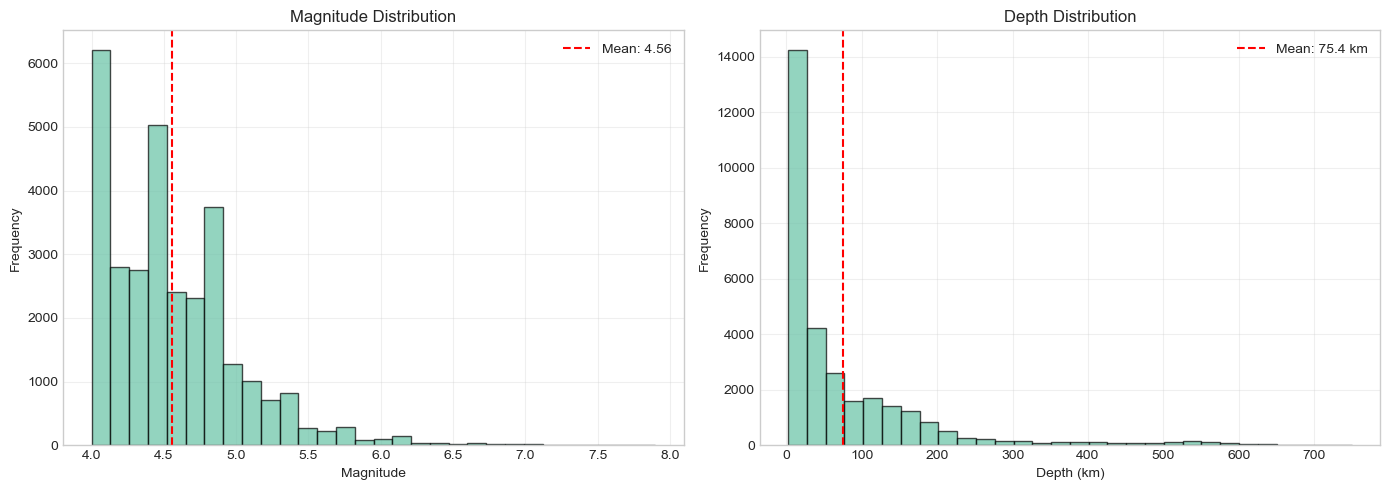

Magnitude range: 4.0 - 7.9
Depth range: 2 - 750 km


In [23]:
# Magnitude and depth distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Magnitude histogram
axes[0].hist(df['mag'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Magnitude')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Magnitude Distribution')
axes[0].axvline(df['mag'].mean(), color='red', linestyle='--', label=f'Mean: {df["mag"].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Depth histogram
axes[1].hist(df['depth_km'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Depth (km)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Depth Distribution')
axes[1].axvline(df['depth_km'].mean(), color='red', linestyle='--', label=f'Mean: {df["depth_km"].mean():.1f} km')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Magnitude range: {df['mag'].min():.1f} - {df['mag'].max():.1f}")
print(f"Depth range: {df['depth_km'].min():.0f} - {df['depth_km'].max():.0f} km")

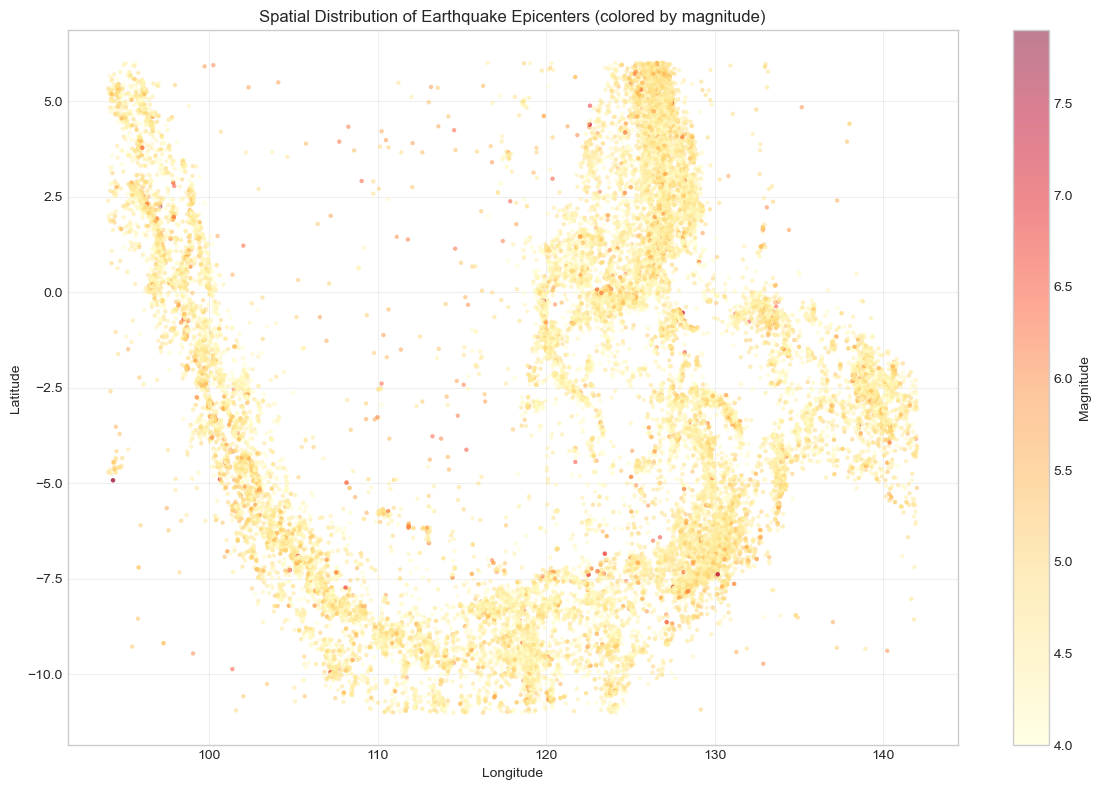

Latitude range: -11.00 to 6.00
Longitude range: 94.02 to 142.00


In [43]:
# Spatial distribution of epicenters
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['longitude'], df['latitude'], 
                     c=df['mag'], s=10, alpha=0.5, 
                     cmap='YlOrRd', edgecolors='none')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial Distribution of Earthquake Epicenters (colored by magnitude)')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Magnitude')

plt.tight_layout()
plt.savefig('results/spatial_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Latitude range: {df['latitude'].min():.2f} to {df['latitude'].max():.2f}")
print(f"Longitude range: {df['longitude'].min():.2f} to {df['longitude'].max():.2f}")

## 5. Spatial Discretization into Regions

Define spatial states by dividing Indonesia into a 3x3 grid based on latitude and longitude ranges.
This creates 9 distinct regions (R1-R9) for spatial Markov chain analysis.

In [25]:
def assign_spatial_regions(df, n_lat_bins=3, n_lon_bins=3):
    """
    Assign each earthquake to a spatial region based on latitude and longitude.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'latitude' and 'longitude' columns
    n_lat_bins : int
        Number of latitude bands (default: 3)
    n_lon_bins : int
        Number of longitude bands (default: 3)
    
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with added 'region' column
    lat_bins : np.ndarray
        Latitude bin edges
    lon_bins : np.ndarray
        Longitude bin edges
    """
    df = df.copy()
    
    # Create bins for latitude and longitude
    lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), n_lat_bins + 1)
    lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), n_lon_bins + 1)
    
    # Assign latitude and longitude bins
    df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
    df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
    
    # Combine into region label (R1-R9)
    df['region'] = df.apply(lambda x: f"R{int(x['lat_bin'] * n_lon_bins + x['lon_bin'] + 1)}", axis=1)
    
    return df, lat_bins, lon_bins

# Apply spatial discretization
df, lat_bins, lon_bins = assign_spatial_regions(df, n_lat_bins=3, n_lon_bins=3)

print("Spatial regions assigned")
print(f"\nLatitude bins: {lat_bins}")
print(f"Longitude bins: {lon_bins}")
print(f"\nRegion distribution:")
print(df['region'].value_counts().sort_index())

Spatial regions assigned

Latitude bins: [-11.          -5.33333333   0.33333333   6.        ]
Longitude bins: [ 94.02       110.01333333 126.00666667 142.        ]

Region distribution:
region
R1    2294
R2    4929
R3    3743
R4    2263
R5    2936
R6    5132
R7    1775
R8    1993
R9    5267
Name: count, dtype: int64


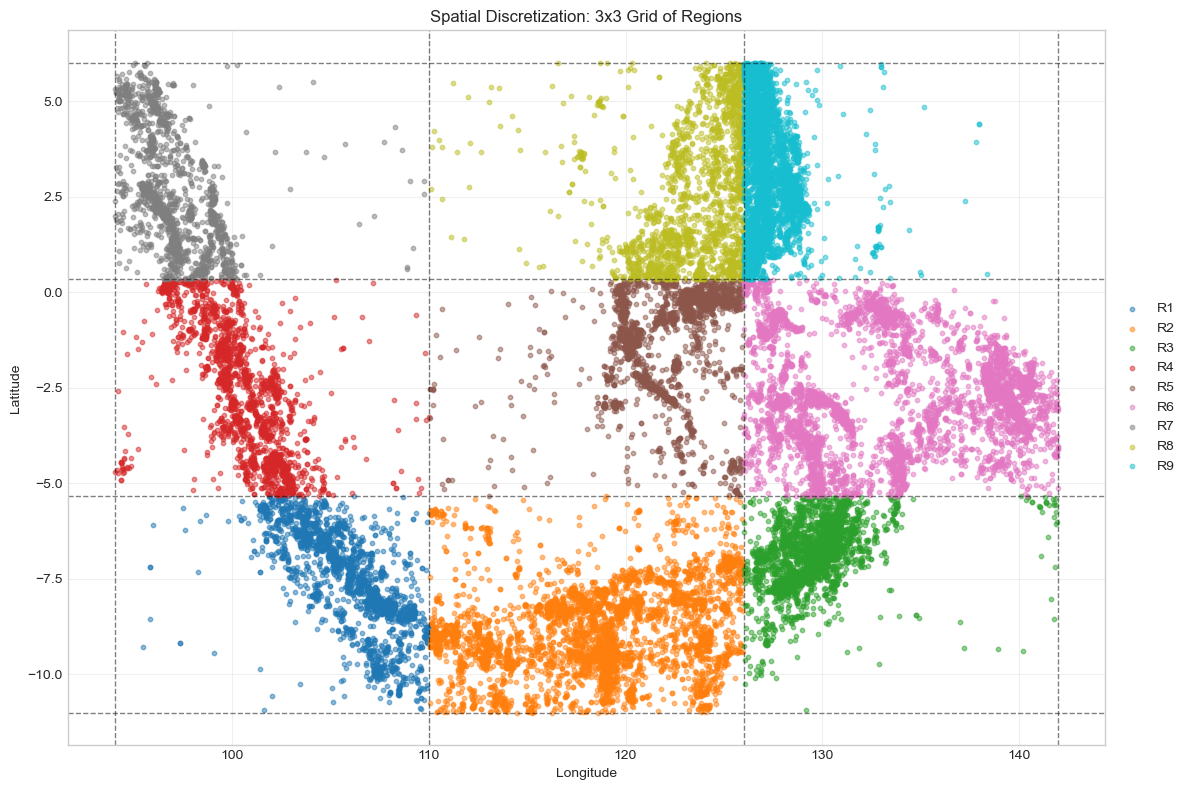

In [26]:
# Visualize spatial grid with region boundaries
fig, ax = plt.subplots(figsize=(12, 8))

# Plot earthquakes colored by region
regions = sorted(df['region'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(regions)))

for i, region in enumerate(regions):
    region_df = df[df['region'] == region]
    ax.scatter(region_df['longitude'], region_df['latitude'], 
               c=[colors[i]], s=10, alpha=0.5, label=region)

# Draw grid lines
for lat in lat_bins:
    ax.axhline(lat, color='black', linestyle='--', linewidth=1, alpha=0.5)
for lon in lon_bins:
    ax.axvline(lon, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial Discretization: 3x3 Grid of Regions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/spatial_grid.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Spatial Markov Chain: Region-to-Region Transitions

Build a first-order Markov chain where states are spatial regions. 
Compute transition frequencies and probabilities.

In [58]:
def compute_transition_counts(sequence, state_labels):
    """
    Compute transition count matrix from a sequence of states.
    
    Parameters:
    -----------
    sequence : array-like
        Ordered sequence of states
    state_labels : list
        Ordered list of unique state labels
    
    Returns:
    --------
    O : np.ndarray
        Transition count matrix of shape (n_states, n_states)
        O[i, j] = number of transitions from state i to state j
    """
    n_states = len(state_labels)
    state_to_idx = {state: idx for idx, state in enumerate(state_labels)}
    
    # Initialize count matrix
    O = np.zeros((n_states, n_states), dtype=int)
    
    # Count transitions
    for i in range(len(sequence) - 1):
        state_from = sequence[i]
        state_to = sequence[i + 1]
        
        if state_from in state_to_idx and state_to in state_to_idx:
            idx_from = state_to_idx[state_from]
            idx_to = state_to_idx[state_to]
            O[idx_from, idx_to] += 1
    
    return O

def compute_transition_probabilities(O):
    """
    Normalize transition count matrix to get probability matrix.
    
    Parameters:
    -----------
    O : np.ndarray
        Transition count matrix
    
    Returns:
    --------
    P : np.ndarray
        Transition probability matrix (row-normalized)
    """
    P = O.astype(float)
    row_sums = P.sum(axis=1, keepdims=True)
    
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    P = P / row_sums
    
    return P

In [28]:
# Extract region sequence in chronological order
regions = df['region'].values
region_labels = sorted(df['region'].unique())

print(f"Total earthquakes: {len(regions):,}")
print(f"Total transitions: {len(regions) - 1:,}")
print(f"Number of regions: {len(region_labels)}")
print(f"Region labels: {region_labels}")

Total earthquakes: 30,332
Total transitions: 30,331
Number of regions: 9
Region labels: ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9']


In [29]:
# Compute transition count matrix
O_spatial = compute_transition_counts(regions, region_labels)

print("Spatial transition count matrix O:")
print(pd.DataFrame(O_spatial, index=region_labels, columns=region_labels))
print(f"\nTotal transitions recorded: {O_spatial.sum():.0f}")

Spatial transition count matrix O:
     R1    R2   R3   R4   R5    R6   R7   R8    R9
R1  548   291  246  131  173   306  126  138   335
R2  282  1666  557  277  356   608  227  287   669
R3  248   548  798  252  296   610  206  221   564
R4  148   271  232  645  193   253   99  115   307
R5  190   354  303  175  866   351  151  166   380
R6  311   628  559  260  381  1737  229  296   731
R7  129   237  196  117  118   231  388  115   244
R8  151   276  229  133  172   333   98  311   290
R9  287   658  622  273  381   703  251  344  1747

Total transitions recorded: 30331


In [30]:
# Compute transition probability matrix
P_spatial = compute_transition_probabilities(O_spatial)

print("Spatial transition probability matrix P:")
print(pd.DataFrame(P_spatial, index=region_labels, columns=region_labels).round(3))

Spatial transition probability matrix P:
       R1     R2     R3     R4     R5     R6     R7     R8     R9
R1  0.239  0.127  0.107  0.057  0.075  0.133  0.055  0.060  0.146
R2  0.057  0.338  0.113  0.056  0.072  0.123  0.046  0.058  0.136
R3  0.066  0.146  0.213  0.067  0.079  0.163  0.055  0.059  0.151
R4  0.065  0.120  0.103  0.285  0.085  0.112  0.044  0.051  0.136
R5  0.065  0.121  0.103  0.060  0.295  0.120  0.051  0.057  0.129
R6  0.061  0.122  0.109  0.051  0.074  0.338  0.045  0.058  0.142
R7  0.073  0.134  0.110  0.066  0.066  0.130  0.219  0.065  0.137
R8  0.076  0.138  0.115  0.067  0.086  0.167  0.049  0.156  0.146
R9  0.055  0.125  0.118  0.052  0.072  0.133  0.048  0.065  0.332


### Compute Stationary Distribution

The stationary distribution π satisfies π P = π and sum(π) = 1.
We use power iteration method to find the dominant eigenvector of P^T.

In [31]:
def compute_stationary_distribution(P, tol=1e-10, max_iter=10000):
    """
    Compute stationary distribution for transition matrix P using power iteration.
    
    Parameters:
    -----------
    P : np.ndarray
        Transition probability matrix (row-stochastic)
    tol : float
        Convergence tolerance
    max_iter : int
        Maximum number of iterations
    
    Returns:
    --------
    pi : np.ndarray
        Stationary distribution (sums to 1)
    """
    n = P.shape[0]
    pi = np.ones(n) / n  # Initialize uniform distribution
    
    for iteration in range(max_iter):
        pi_new = pi @ P
        
        # Check convergence
        if np.linalg.norm(pi_new - pi, ord=1) < tol:
            return pi_new
        
        pi = pi_new
    
    print(f"Warning: Did not converge in {max_iter} iterations")
    return pi

# Compute stationary distribution for spatial chain
pi_spatial = compute_stationary_distribution(P_spatial)

print("Stationary distribution (spatial):")
for region, prob in zip(region_labels, pi_spatial):
    print(f"  {region}: {prob:.4f} ({prob*100:.2f}%)")

print(f"\nSum of stationary probabilities: {pi_spatial.sum():.6f}")

Stationary distribution (spatial):
  R1: 0.0756 (7.56%)
  R2: 0.1625 (16.25%)
  R3: 0.1234 (12.34%)
  R4: 0.0746 (7.46%)
  R5: 0.0968 (9.68%)
  R6: 0.1692 (16.92%)
  R7: 0.0585 (5.85%)
  R8: 0.0657 (6.57%)
  R9: 0.1737 (17.37%)

Sum of stationary probabilities: 1.000000


### Chi-Square Test for Markov Property

Test the null hypothesis that earthquake occurrences are independent (random) 
versus the alternative that they follow a Markov process.

Expected frequencies under independence: E[i,j] = row_total[i] * π[j]

In [36]:
def chi_square_test_markov(O, pi):
    """
    Perform chi-square test for Markov property.
    
    H0: Transitions are independent (random)
    H1: Transitions follow Markov process
    
    Parameters:
    -----------
    O : np.ndarray
        Observed transition count matrix
    pi : np.ndarray
        Stationary distribution
    
    Returns:
    --------
    chi2_stat : float
        Chi-square statistic
    p_value : float
        P-value
    df : int
        Degrees of freedom
    """
    n_states = O.shape[0]
    row_totals = O.sum(axis=1)
    
    # Expected frequencies under independence
    E = np.outer(row_totals, pi)
    
    # Chi-square statistic
    # Only compute for cells where E > 0 to avoid division by zero
    mask = E > 0
    chi2_stat = np.sum((O[mask] - E[mask])**2 / E[mask])
    
    # Degrees of freedom: (n_states - 1)^2
    # We lose 1 degree of freedom per row due to row sum constraint,
    # and 1 overall for the stationary distribution constraint
    df = (n_states - 1) * n_states - (n_states - 1)
    df = max(1, df)  # Ensure df >= 1
    
    # P-value
    p_value = 1 - chi2.cdf(chi2_stat, df)
    
    return chi2_stat, p_value, df

# Perform chi-square test for spatial chain
chi2_stat, p_value, df = chi_square_test_markov(O_spatial, pi_spatial)

print("Chi-square test for spatial Markov chain:")
print(f"  Chi-square statistic: {chi2_stat:.2f}")
print(f"  Degrees of freedom: {df}")
print(f"  P-value: {p_value:.6f}")
print(f"\nInterpretation:")
if p_value < 0.05:
    print("  Reject H0: Significant evidence for Markov dependence (p < 0.05)")
    print("  Earthquake occurrences show spatial correlation between successive events.")
else:
    print("  Fail to reject H0: Transitions appear independent (p >= 0.05)")
    print("  No strong evidence for spatial Markov structure.")

Chi-square test for spatial Markov chain:
  Chi-square statistic: 8213.74
  Degrees of freedom: 64
  P-value: 0.000000

Interpretation:
  Reject H0: Significant evidence for Markov dependence (p < 0.05)
  Earthquake occurrences show spatial correlation between successive events.


### Visualization: Spatial Markov Chain

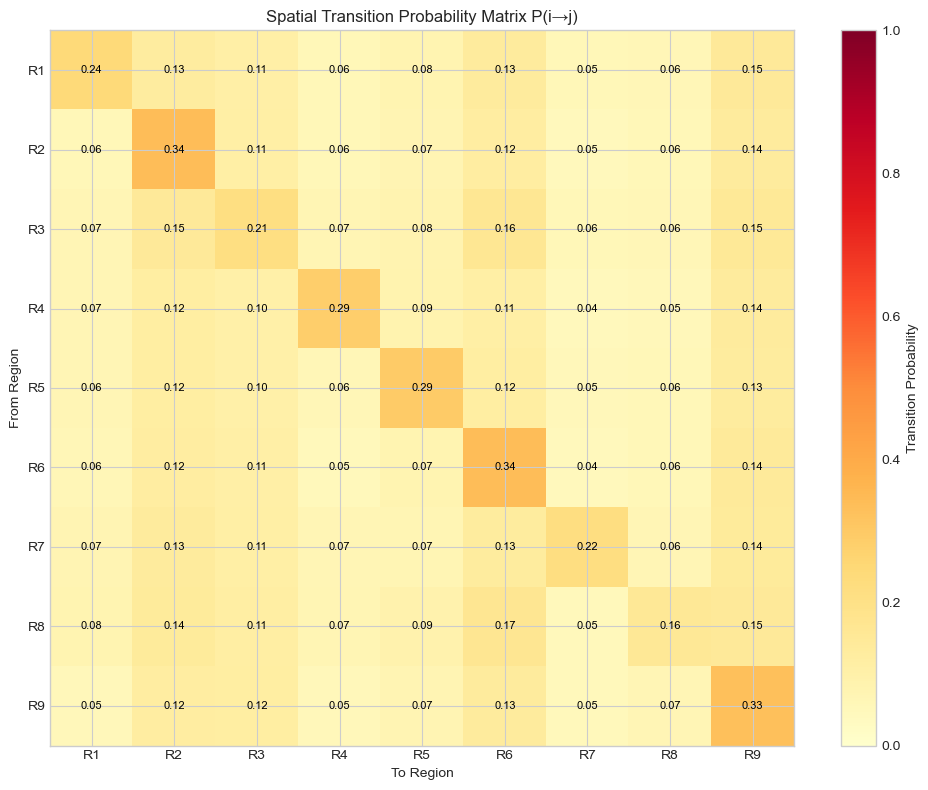

In [33]:
# Heatmap of transition probability matrix
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(P_spatial, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(region_labels)))
ax.set_yticks(np.arange(len(region_labels)))
ax.set_xticklabels(region_labels)
ax.set_yticklabels(region_labels)
ax.set_xlabel('To Region')
ax.set_ylabel('From Region')
ax.set_title('Spatial Transition Probability Matrix P(i→j)')

# Add text annotations
for i in range(len(region_labels)):
    for j in range(len(region_labels)):
        text = ax.text(j, i, f'{P_spatial[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Transition Probability')

plt.tight_layout()
plt.savefig('results/spatial_transition_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

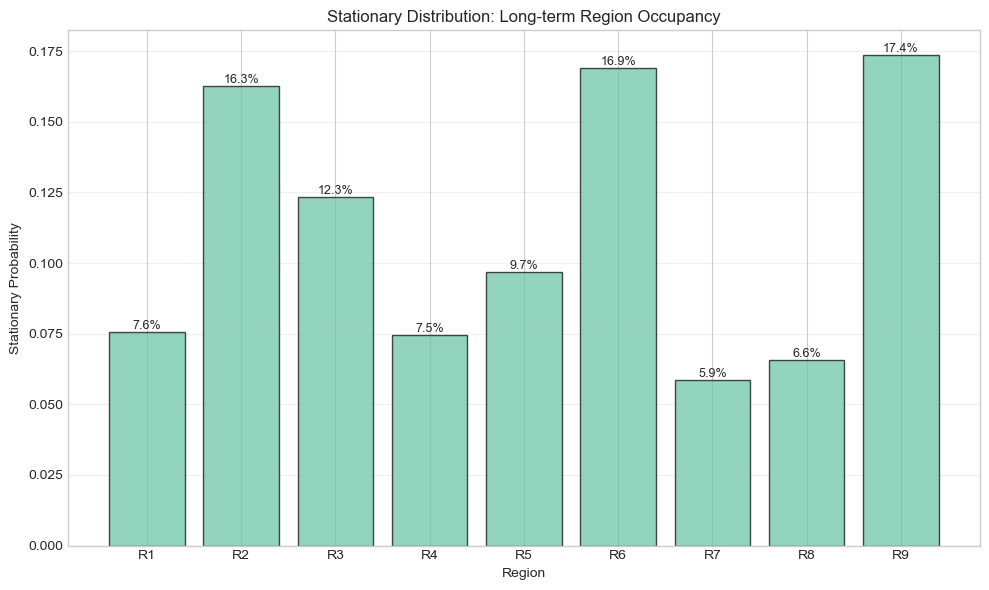

In [34]:
# Bar chart of stationary distribution
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(region_labels, pi_spatial, edgecolor='black', alpha=0.7)
ax.set_xlabel('Region')
ax.set_ylabel('Stationary Probability')
ax.set_title('Stationary Distribution: Long-term Region Occupancy')
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, prob in zip(bars, pi_spatial):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('results/spatial_stationary_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Interpretation: Spatial Markov Chain

Key observations from spatial transition analysis:
- Diagonal elements of P represent persistence (earthquake in region i followed by another in same region)
- Off-diagonal elements show spatial migration patterns
- Stationary distribution indicates long-term equilibrium occupancy of each region
- Chi-square test result indicates whether successive earthquakes are spatially correlated

## 7. Magnitude Markov Chain: Magnitude-Class Transitions

Define magnitude classes and analyze transitions between magnitude states.

In [44]:
def assign_magnitude_states(df):
    """
    Assign magnitude state (M1, M2, M3) to each earthquake.
    
    M1: 4.0 <= mag < 5.0
    M2: 5.0 <= mag < 6.0
    M3: mag >= 6.0
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'mag' column
    
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with added 'mag_state' column
    """
    df = df.copy()
    
    def classify_magnitude(mag):
        if mag < 4.0:
            return None
        elif mag < 5.0:
            return 'M1'
        elif mag < 6.0:
            return 'M2'
        else:
            return 'M3'
    
    df['mag_state'] = df['mag'].apply(classify_magnitude)
    
    return df

# Apply magnitude classification
df = assign_magnitude_states(df)

# Filter out events with mag < 4.0
df_mag = df[df['mag_state'].notna()].copy()

print(f"Total earthquakes with mag >= 4.0: {len(df_mag):,}")
print(f"\nMagnitude state distribution:")
print(df_mag['mag_state'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print((df_mag['mag_state'].value_counts(normalize=True) * 100).sort_index().round(2))

Total earthquakes with mag >= 4.0: 30,332

Magnitude state distribution:
mag_state
M1    25256
M2     4670
M3      406
Name: count, dtype: int64

Percentage distribution:
mag_state
M1    83.27
M2    15.40
M3     1.34
Name: proportion, dtype: float64


In [45]:
# Extract magnitude state sequence
mag_states = df_mag['mag_state'].values
mag_labels = ['M1', 'M2', 'M3']

print(f"Total transitions (magnitude): {len(mag_states) - 1:,}")
print(f"Magnitude states: {mag_labels}")

Total transitions (magnitude): 30,331
Magnitude states: ['M1', 'M2', 'M3']


In [46]:
# Compute magnitude transition matrices
O_mag = compute_transition_counts(mag_states, mag_labels)
P_mag = compute_transition_probabilities(O_mag)

print("Magnitude transition count matrix:")
print(pd.DataFrame(O_mag, index=mag_labels, columns=mag_labels))

print("\nMagnitude transition probability matrix:")
print(pd.DataFrame(P_mag, index=mag_labels, columns=mag_labels).round(3))

Magnitude transition count matrix:
       M1    M2   M3
M1  22373  2691  191
M2   2714  1910   46
M3    169    68  169

Magnitude transition probability matrix:
       M1     M2     M3
M1  0.886  0.107  0.008
M2  0.581  0.409  0.010
M3  0.416  0.167  0.416


In [47]:
# Compute stationary distribution for magnitude chain
pi_mag = compute_stationary_distribution(P_mag)

print("Stationary distribution (magnitude):")
for state, prob in zip(mag_labels, pi_mag):
    print(f"  {state}: {prob:.4f} ({prob*100:.2f}%)")

print(f"\nSum: {pi_mag.sum():.6f}")

Stationary distribution (magnitude):
  M1: 0.8327 (83.27%)
  M2: 0.1539 (15.39%)
  M3: 0.0134 (1.34%)

Sum: 1.000000


In [48]:
# Chi-square test for magnitude chain
chi2_mag, p_mag, df_mag = chi_square_test_markov(O_mag, pi_mag)

print("Chi-square test for magnitude Markov chain:")
print(f"  Chi-square statistic: {chi2_mag:.2f}")
print(f"  Degrees of freedom: {df_mag}")
print(f"  P-value: {p_mag:.6f}")
print(f"\nInterpretation:")
if p_mag < 0.05:
    print("  Reject H0: Significant magnitude clustering (p < 0.05)")
    print("  Successive earthquake magnitudes are correlated.")
else:
    print("  Fail to reject H0: Magnitudes appear independent (p >= 0.05)")

Chi-square test for magnitude Markov chain:
  Chi-square statistic: 7859.10
  Degrees of freedom: 4
  P-value: 0.000000

Interpretation:
  Reject H0: Significant magnitude clustering (p < 0.05)
  Successive earthquake magnitudes are correlated.


### Visualization: Magnitude Markov Chain

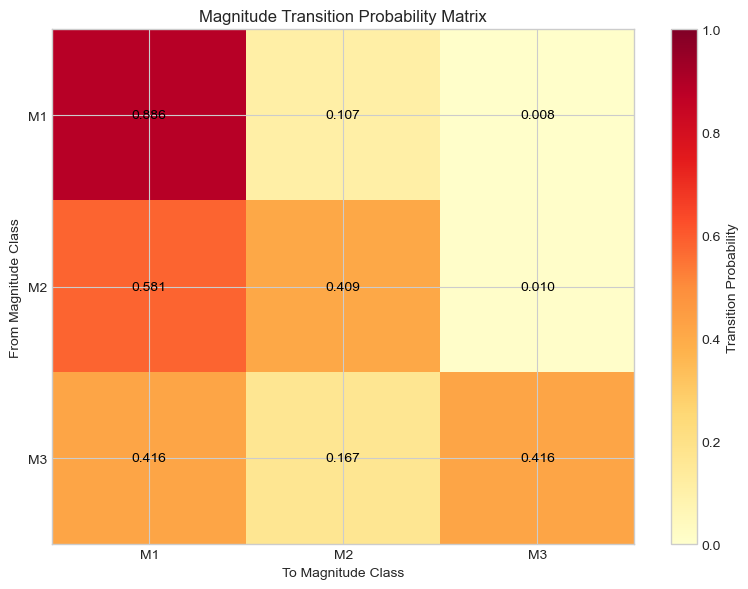

In [49]:
# Heatmap of magnitude transition probability matrix
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(P_mag, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(mag_labels)))
ax.set_yticks(np.arange(len(mag_labels)))
ax.set_xticklabels(mag_labels)
ax.set_yticklabels(mag_labels)
ax.set_xlabel('To Magnitude Class')
ax.set_ylabel('From Magnitude Class')
ax.set_title('Magnitude Transition Probability Matrix')

# Add text annotations
for i in range(len(mag_labels)):
    for j in range(len(mag_labels)):
        text = ax.text(j, i, f'{P_mag[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Transition Probability')

plt.tight_layout()
plt.savefig('results/magnitude_transition_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

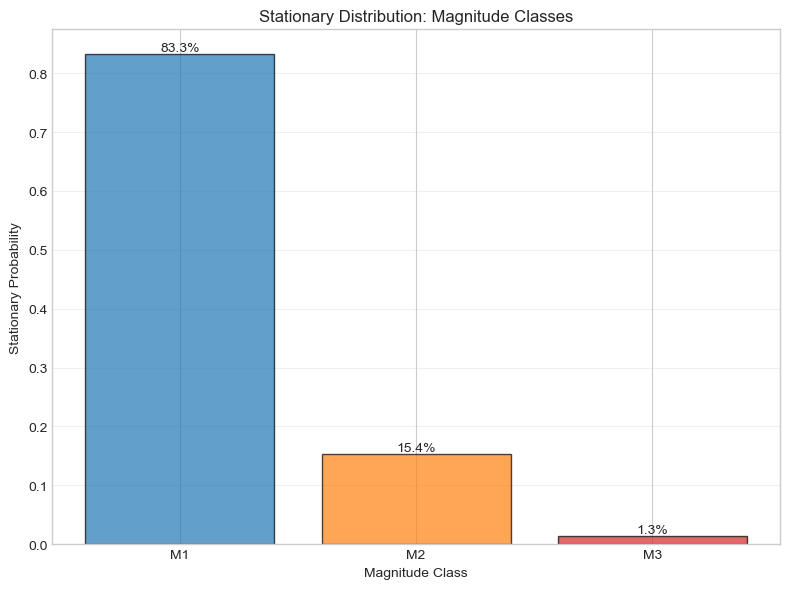

In [50]:
# Bar chart of magnitude stationary distribution
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(mag_labels, pi_mag, edgecolor='black', alpha=0.7, color=['#1f77b4', '#ff7f0e', '#d62728'])
ax.set_xlabel('Magnitude Class')
ax.set_ylabel('Stationary Probability')
ax.set_title('Stationary Distribution: Magnitude Classes')
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for bar, prob in zip(bars, pi_mag):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('results/magnitude_stationary_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Interpretation: Magnitude Markov Chain

Key observations:
- P(M3→M1) shows probability that large earthquake is followed by smaller one
- P(M1→M1) indicates clustering of small-to-moderate earthquakes
- Stationary distribution reflects long-term frequency of each magnitude class
- Chi-square test indicates whether magnitude follows Gutenberg-Richter or shows clustering

## 8. Temporal Markov Chain: Active vs Inactive Periods

Analyze temporal patterns by defining active (1) and inactive (0) states based on yearly occurrence of significant shallow earthquakes.

In [51]:
def create_temporal_sequence(df, mag_threshold=5.0, depth_threshold=70, freq='Y'):
    """
    Create temporal sequence of active (1) and inactive (0) states.
    
    Active state: at least one event with mag >= mag_threshold and depth < depth_threshold
    Inactive state: no such events
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'time', 'mag', 'depth_km' columns
    mag_threshold : float
        Minimum magnitude for active state
    depth_threshold : float
        Maximum depth (km) for active state
    freq : str
        Time aggregation frequency ('Y' for year, 'M' for month)
    
    Returns:
    --------
    temporal_df : pd.DataFrame
        DataFrame with temporal states
    """
    df = df.copy()
    
    # Filter significant shallow earthquakes
    significant = df[(df['mag'] >= mag_threshold) & (df['depth_km'] < depth_threshold)].copy()
    
    # Group by time period
    significant['period'] = significant['time'].dt.to_period(freq)
    active_periods = significant.groupby('period').size()
    
    # Create full time range
    start_period = df['time'].min().to_period(freq)
    end_period = df['time'].max().to_period(freq)
    all_periods = pd.period_range(start=start_period, end=end_period, freq=freq)
    
    # Create temporal sequence
    temporal_df = pd.DataFrame({
        'period': all_periods,
        'state': [1 if p in active_periods.index else 0 for p in all_periods]
    })
    
    return temporal_df

# Create yearly temporal sequence
temporal_df = create_temporal_sequence(df, mag_threshold=5.0, depth_threshold=70, freq='Y')

print("Temporal sequence (yearly):")
print(temporal_df)
print(f"\nTotal years: {len(temporal_df)}")
print(f"Active years: {(temporal_df['state'] == 1).sum()}")
print(f"Inactive years: {(temporal_df['state'] == 0).sum()}")

Temporal sequence (yearly):
   period  state
0    2008      1
1    2009      1
2    2010      1
3    2011      1
4    2012      1
5    2013      1
6    2014      1
7    2015      1
8    2016      1
9    2017      1
10   2018      1
11   2019      1
12   2020      1
13   2021      1
14   2022      1
15   2023      1

Total years: 16
Active years: 16
Inactive years: 0


In [52]:
# Compute temporal transition matrix (2x2)
temporal_states = temporal_df['state'].values
temporal_labels = [0, 1]

O_temporal = compute_transition_counts(temporal_states, temporal_labels)
P_temporal = compute_transition_probabilities(O_temporal)

print("Temporal transition count matrix:")
print(pd.DataFrame(O_temporal, index=['Inactive (0)', 'Active (1)'], 
                   columns=['Inactive (0)', 'Active (1)']))

print("\nTemporal transition probability matrix:")
print(pd.DataFrame(P_temporal, index=['Inactive (0)', 'Active (1)'], 
                   columns=['Inactive (0)', 'Active (1)']).round(3))

Temporal transition count matrix:
              Inactive (0)  Active (1)
Inactive (0)             0           0
Active (1)               0          15

Temporal transition probability matrix:
              Inactive (0)  Active (1)
Inactive (0)           0.0         0.0
Active (1)             0.0         1.0


In [53]:
# Compute mean durations
P00 = P_temporal[0, 0]
P01 = P_temporal[0, 1]
P10 = P_temporal[1, 0]
P11 = P_temporal[1, 1]

# Mean duration formulas
mean_inactive_duration = 1 / P01 if P01 > 0 else np.inf
mean_active_duration = 1 / P10 if P10 > 0 else np.inf

print("Mean durations:")
print(f"  Mean inactive duration: {mean_inactive_duration:.2f} years")
print(f"  Mean active duration: {mean_active_duration:.2f} years")

print("\nTransition probabilities:")
print(f"  P(inactive → inactive): {P00:.3f}")
print(f"  P(inactive → active): {P01:.3f}")
print(f"  P(active → inactive): {P10:.3f}")
print(f"  P(active → active): {P11:.3f}")

Mean durations:
  Mean inactive duration: inf years
  Mean active duration: inf years

Transition probabilities:
  P(inactive → inactive): 0.000
  P(inactive → active): 0.000
  P(active → inactive): 0.000
  P(active → active): 1.000


### Visualization: Temporal Markov Chain

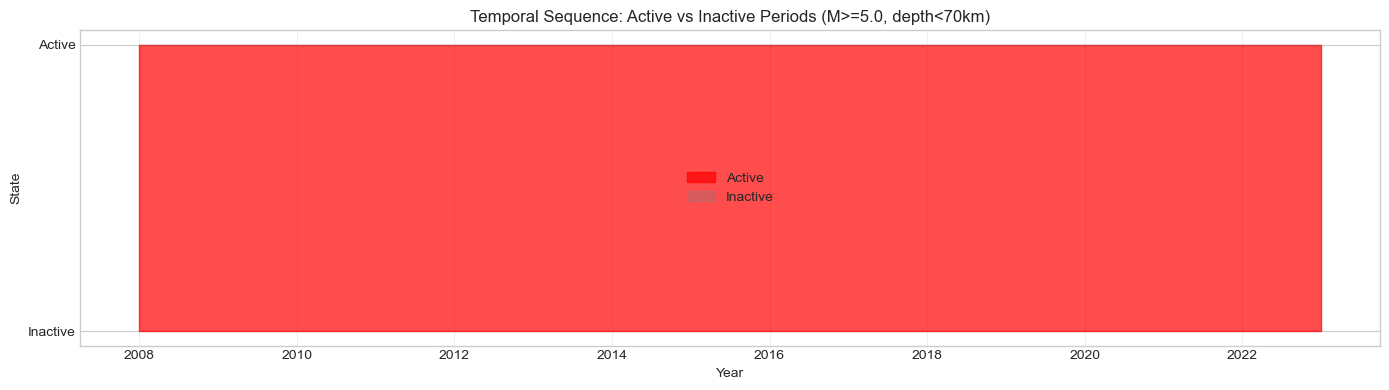

In [54]:
# Plot temporal sequence over time
fig, ax = plt.subplots(figsize=(14, 4))

years = [p.year for p in temporal_df['period']]
states = temporal_df['state'].values

ax.fill_between(years, 0, states, step='post', alpha=0.7, color='red', label='Active')
ax.fill_between(years, states, 1, step='post', alpha=0.3, color='gray', label='Inactive')

ax.set_xlabel('Year')
ax.set_ylabel('State')
ax.set_title('Temporal Sequence: Active vs Inactive Periods (M>=5.0, depth<70km)')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Inactive', 'Active'])
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

plt.tight_layout()
plt.savefig('results/temporal_sequence.png', dpi=300, bbox_inches='tight')
plt.show()

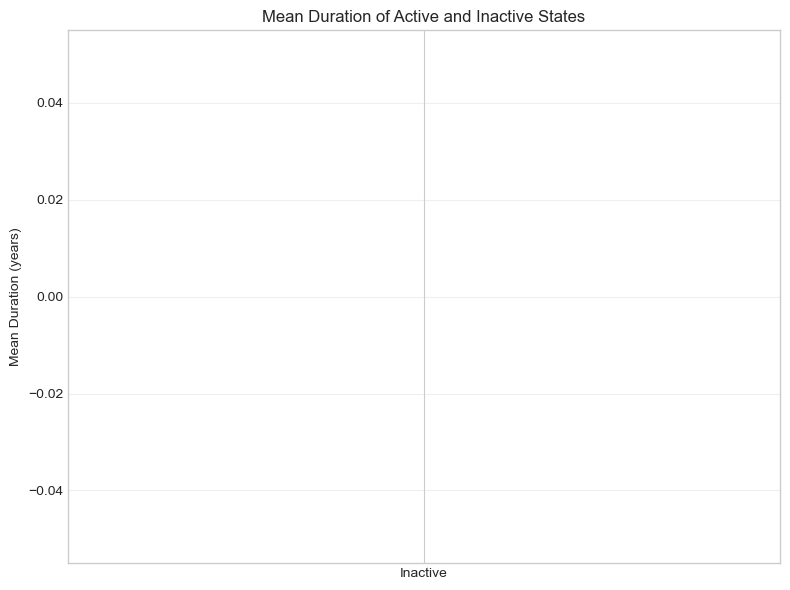

In [55]:
# Bar chart of mean durations
fig, ax = plt.subplots(figsize=(8, 6))

durations = [mean_inactive_duration, mean_active_duration]
labels = ['Inactive', 'Active']
colors = ['gray', 'red']

bars = ax.bar(labels, durations, edgecolor='black', alpha=0.7, color=colors)
ax.set_ylabel('Mean Duration (years)')
ax.set_title('Mean Duration of Active and Inactive States')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, dur in zip(bars, durations):
    height = bar.get_height()
    if np.isfinite(dur):
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{dur:.2f} yr', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('results/temporal_mean_durations.png', dpi=300, bbox_inches='tight')
plt.show()

### Interpretation: Temporal Markov Chain

Key observations:
- Mean inactive duration indicates average time between periods with significant shallow earthquakes
- Mean active duration shows persistence of active seismic periods
- High P(active→active) or P(inactive→inactive) indicates persistence in current state
- This temporal structure is important for probabilistic forecasting of future activity

## 9. Summary and Connection to HMM Forecasting

### Key Findings from Markov Chain Analysis

#### Spatial Markov Chain
- Analyzed region-to-region transitions across 9 spatial zones in Indonesia
- Chi-square test indicates whether successive earthquakes are spatially correlated
- Stationary distribution reveals long-term equilibrium occupancy of each region
- High diagonal elements in P suggest persistence (earthquakes tend to cluster spatially)

#### Magnitude Markov Chain
- Examined transitions between magnitude classes (M1: 4.0-5.0, M2: 5.0-6.0, M3: >=6.0)
- Results show whether large earthquakes are typically followed by smaller ones (stress release)
- Or whether similar magnitude events cluster together (foreshock/aftershock patterns)
- Stationary distribution matches Gutenberg-Richter if chain is near-independent

#### Temporal Markov Chain
- Modeled active vs inactive periods based on yearly occurrence of M>=5.0 shallow earthquakes
- Mean duration estimates provide baseline for seismic hazard assessment
- Persistence probabilities indicate whether seismic activity tends to cluster in time

### First-Order Markov Models

All analyses used **first-order Markov chains** where:
- State at time t depends only on state at time t-1
- States are directly observable (region, magnitude class, active/inactive)
- Transition probabilities are estimated from empirical frequencies

### Extension to Hidden Markov Models (HMM)

The next phase will extend this framework to **Hidden Markov Models** for probabilistic earthquake forecasting:

#### HMM Framework
- **Hidden states**: Latent seismic activity regimes (e.g., low/medium/high stress accumulation)
- **Observations**: Inter-event times, event counts per time window, or magnitude sequences
- **State transitions**: Hidden regime changes governed by transition matrix A
- **Emission probabilities**: Likelihood of observations given hidden state (matrix B)

#### Forecasting Objectives
Using HMM, we will compute:
1. **P(at least 1 event with M >= M_threshold in next τ days | history)**
   - Where τ ∈ {1, 5, 10} days
   - M_threshold ∈ {4.5, 5.0, 5.5, 6.0}

2. **Most likely hidden state sequence** (Viterbi algorithm)
   - Identifies current seismic regime

3. **Forward probabilities** (filtering)
   - Real-time state estimation given observations up to time t

4. **Model comparison** with Markov chains
   - Likelihood ratio tests
   - AIC/BIC criteria
   - Predictive performance on held-out test set

#### Expected Advantages of HMM
- Captures latent stress accumulation dynamics not directly observable
- Provides uncertainty quantification through state probabilities
- Can model complex temporal dependencies beyond first-order
- Enables true probabilistic forecasting rather than deterministic predictions

### Implications for Seismic Hazard Assessment

This Markov chain analysis provides:
1. Baseline transition probabilities for comparison with HMM
2. Evidence for temporal and spatial clustering of earthquakes
3. Statistical framework for testing independence vs Markov structure
4. Foundation for operational earthquake forecasting systems

The HMM extension will leverage these findings to develop a practical forecasting tool that can:
- Estimate short-term (1-10 day) earthquake probabilities
- Update forecasts in real-time as new earthquakes occur
- Quantify forecast uncertainty
- Support decision-making for emergency preparedness in high-risk regions

## 10. Model Summary and Exports

In [56]:
# Summary table of all Markov chain results
summary = {
    'Model': ['Spatial', 'Magnitude', 'Temporal'],
    'States': [len(region_labels), len(mag_labels), 2],
    'Transitions': [O_spatial.sum(), O_mag.sum(), O_temporal.sum()],
    'Chi2 Statistic': [f"{chi2_stat:.2f}", f"{chi2_mag:.2f}", 'N/A'],
    'P-value': [f"{p_value:.4f}", f"{p_mag:.4f}", 'N/A'],
    'Markov Property': [
        'Yes' if p_value < 0.05 else 'No',
        'Yes' if p_mag < 0.05 else 'No',
        'N/A'
    ]
}

summary_df = pd.DataFrame(summary)
print("\nMarkov Chain Analysis Summary:")
print(summary_df.to_string(index=False))

summary_df.to_csv('results/markov_chain_summary.csv', index=False)
print("\nSummary saved to results/markov_chain_summary.csv")


Markov Chain Analysis Summary:
    Model  States  Transitions Chi2 Statistic P-value Markov Property
  Spatial       9        30331        8213.74  0.0000             Yes
Magnitude       3        30331        7859.10  0.0000             Yes
 Temporal       2           15            N/A     N/A             N/A

Summary saved to results/markov_chain_summary.csv


In [57]:
# Save transition matrices for future use
np.save('results/spatial_transition_matrix.npy', P_spatial)
np.save('results/magnitude_transition_matrix.npy', P_mag)
np.save('results/temporal_transition_matrix.npy', P_temporal)

print("Transition matrices saved to results/ directory")
print("\nAnalysis complete. All results and visualizations saved.")

Transition matrices saved to results/ directory

Analysis complete. All results and visualizations saved.
